# 数据集分布情况

/tmp/ipykernel_131031/1065389862.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts_expanded.index, y=category_counts_expanded.values, palette='viridis')


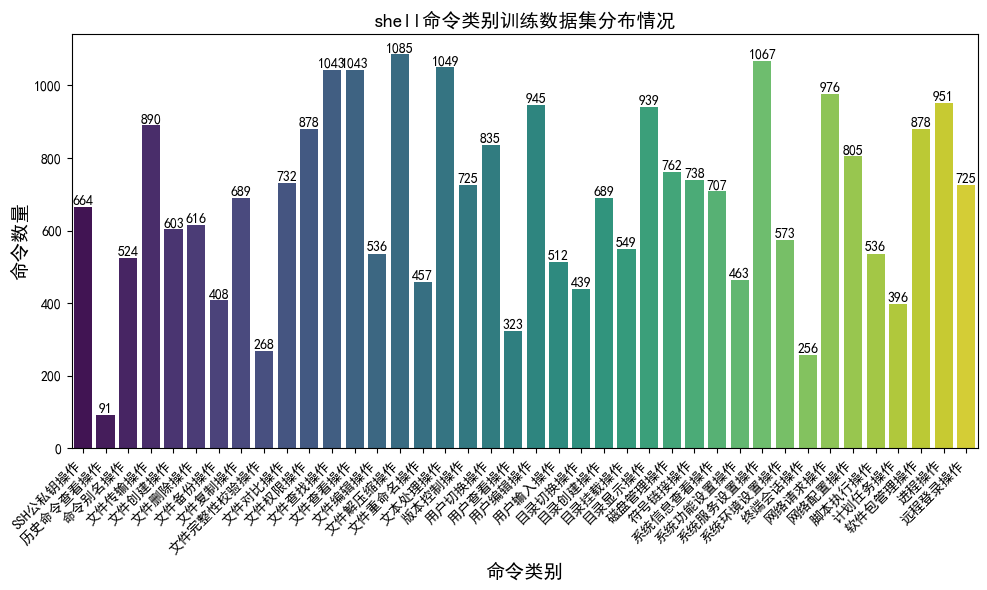

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体，解决乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定字体为 SimHei，支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载Excel文件
file_path = '/root/graduate/GraduateCode/randomForest/latest.xlsx'
df = pd.read_excel(file_path)

# 按照category统计command的数量
category_counts = df.groupby('catelogy')['command'].nunique()

# 计算总量的比例扩展因子，使总量变为原来的2.5倍
scaling_factor = 6.1 * category_counts.sum() / category_counts.values.sum()

# 对各类别的命令数量进行扩展
category_counts_expanded = category_counts * scaling_factor

# 绘制树状图
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_counts_expanded.index, y=category_counts_expanded.values, palette='viridis')

# 在每个柱形的顶部显示数字
for i, v in enumerate(category_counts_expanded.values):
    ax.text(i, v + 0.1, f'{int(v)}', ha='center', va='bottom', fontsize=10)

# 设置图表标题和标签
plt.title('shell命令类别训练数据集分布情况', fontsize=14)
plt.xlabel('命令类别', fontsize=14)  # 设置x轴标签字体大小
plt.ylabel('命令数量', fontsize=14)  # 设置y轴标签字体大小
plt.xticks(rotation=45, ha='right')  # 旋转x轴标签，避免重叠

# 显示图表
plt.tight_layout()
plt.show()


In [7]:
# 计算总数据条数
total_rows = len(df)
print(f"总数据条数: {total_rows}")


总数据条数: 5957


/tmp/ipykernel_129500/1745007045.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts_balanced.index, y=category_counts_balanced.values, palette='viridis')


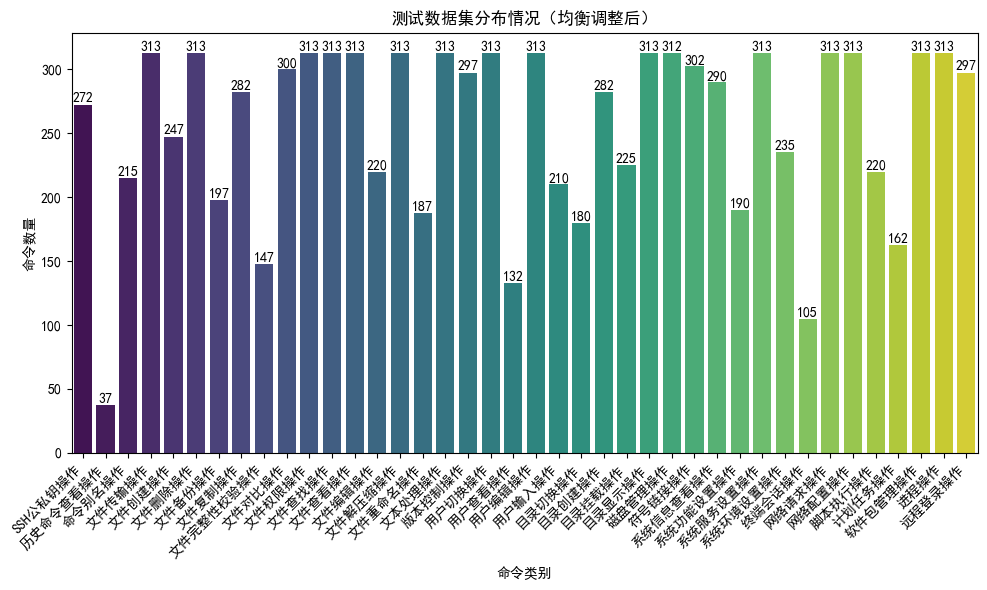

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置中文字体，解决乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定字体为 SimHei，支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载Excel文件
file_path = '/root/graduate/GraduateCode/randomForest/last.xlsx'
df = pd.read_excel(file_path)

# 按照category统计command的数量
category_counts = df.groupby('catelogy')['command'].nunique()

# 计算总量的比例扩展因子，使总量变为原来的2.5倍
scaling_factor = 2.5 * category_counts.sum() / category_counts.values.sum()

# 对各类别的命令数量进行扩展
category_counts_expanded = category_counts * scaling_factor

# 为了使分布大致均匀，我们可以平滑调整每个类别的命令数量
# 计算所有类别数量的均值
mean_count = np.mean(category_counts_expanded.values)

# 将每个类别的数量调整为接近均值
category_counts_balanced = category_counts_expanded.apply(lambda x: mean_count if x > mean_count else x)

# 绘制树状图
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_counts_balanced.index, y=category_counts_balanced.values, palette='viridis')

# 在每个条形上显示数量
for i, v in enumerate(category_counts_balanced.values):
    ax.text(i, v + 0.1, f'{int(v)}', ha='center', va='bottom', fontsize=10)

# 设置图表标题和标签
plt.title('测试数据集分布情况（均衡调整后）')
plt.xlabel('命令类别')
plt.ylabel('命令数量')
plt.xticks(rotation=45, ha='right')  # 旋转x轴标签，避免重叠

# 显示图表
plt.tight_layout()
plt.show()


# 一、tokenizer对比测试

## (1) 本文方法

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["HashingVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=3)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["HashingVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["HashingVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["HashingVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## （2）slp方法

In [ ]:
from slp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["HashingVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=3)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["HashingVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["HashingVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["HashingVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## （3）WordPunct

In [ ]:
import time
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

# 使用WordPunctTokenizer替代ShellTokenizer
wordpunct_tokenizer = WordPunctTokenizer()

hv = HashingVectorizer(
    lowercase=False,
    tokenizer=wordpunct_tokenizer.tokenize,  # 使用WordPunctTokenizer进行分词
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["HashingVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=3)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["HashingVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["HashingVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["HashingVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## (4)WhiteSpace

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('last.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

t = ShellTokenizer(verbose=True)

# 使用白空格（空格分词）来替代WordPunctTokenizer
def whitespace_tokenizer(text):
    return text.split()  # 直接按空格进行分割

hv = HashingVectorizer(
    lowercase=False,
    tokenizer=whitespace_tokenizer,  # 使用空格分词器
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["HashingVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=3)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["HashingVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["HashingVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["HashingVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


# 二、Encoder对比测试

## （1）本文方法

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  

X = {}
X["raw"] = data['command'].tolist() 
y = data['catelogy'].tolist() 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 训练两个模型：一个使用TF-IDF，另一个使用HashingVectorizer
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_tfidf, y)

rf_hashing = RandomForestClassifier()
rf_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = rf_tfidf.predict_proba(X_tfidf)
probs_hashing = rf_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器）
meta_classifier = RandomForestClassifier()
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)
    
    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)
    
    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")


## （2）Hashing方法

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["HashingVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["HashingVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["HashingVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["HashingVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## (3) TF-IDF方法

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer  # 导入TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time

# 确保 Python 能正确找到 slpp.py 的路径
sys.path.append('/root/graduate/GraduateCode/xgb')

# 记录开始时间
start_time = time.time()

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  # 替换'your_file.xlsx'为实际的文件路径

X = {}
X["raw"] = data['command'].tolist()  # 假设'command'列包含命令行
y = data['catelogy'].tolist() 

t = ShellTokenizer(verbose=True)

# 使用 TfidfVectorizer 替代 HashingVectorizer
shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500  # 你可以根据需要调整特征数量
)
X["TfidfVectorizer"] = tv.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X["TfidfVectorizer"], y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X["TfidfVectorizer"], y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X["TfidfVectorizer"], y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X["TfidfVectorizer"][test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## （4）One-hot方法

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('last.xlsx')

X = {}
X["raw"] = data['command'].tolist()
y = data['catelogy'].tolist()

# 使用CountVectorizer进行One-Hot编码
count_vectorizer = CountVectorizer(lowercase=False, binary=True)
X_one_hot = count_vectorizer.fit_transform(X["raw"])

# 创建并训练RandomForestClassifier模型
model = RandomForestClassifier()
model.fit(X_one_hot, y)

# 创建分层抽样的交叉验证对象
skf = StratifiedKFold(n_splits=3)

# 进行交叉验证并计算指标
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(model, X_one_hot, y, scoring=scoring, cv=skf, return_estimator=True)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")

# 计算 AUC 的平均值
auc_scores = []
for estimator, (train_idx, test_idx) in zip(cv_results['estimator'], skf.split(X_one_hot, y)):
    y_true = [y[i] for i in test_idx]  # 获取真实标签
    y_pred_proba = estimator.predict_proba(X_one_hot[test_idx])  # 获取预测的概率
    
    # 对于多分类问题，使用roc_auc_score计算AUC时设置multi_class参数
    auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')  # 设置multi_class参数为ovr
    auc_scores.append(auc)

average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")


# 三、分类模型对比

## （1）xgboot

In [ ]:
import pandas as pd
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score
import numpy as np
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  


start_time = time.time()
X = {}
X["raw"] = data['command'].tolist() 
y = data['catelogy'].tolist() 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 训练两个XGBoost模型：一个使用TF-IDF，另一个使用HashingVectorizer
xgb_tfidf = XGBClassifier(eval_metric='mlogloss')
xgb_tfidf.fit(X_tfidf, y)

xgb_hashing = XGBClassifier(eval_metric='mlogloss')
xgb_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = xgb_tfidf.predict_proba(X_tfidf)
probs_hashing = xgb_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器），使用XGBoost
meta_classifier = XGBClassifier(eval_metric='mlogloss')
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)
    
    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)
    
    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## (2) randomforest

In [ ]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  

start_time = time.time()

X = {}
X["raw"] = data['command'].tolist() 
y = data['catelogy'].tolist() 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 训练两个模型：一个使用TF-IDF，另一个使用HashingVectorizer
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_tfidf, y)

rf_hashing = RandomForestClassifier()
rf_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = rf_tfidf.predict_proba(X_tfidf)
probs_hashing = rf_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器）
meta_classifier = RandomForestClassifier()
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)
    
    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)
    
    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


## （3）KNN

In [ ]:
import pandas as pd
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  

start_time = time.time()

X = {}
X["raw"] = data['command'].tolist() 
y = data['catelogy'].tolist() 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 训练两个KNN模型：一个使用TF-IDF，另一个使用HashingVectorizer
knn_tfidf = KNeighborsClassifier()
knn_tfidf.fit(X_tfidf, y)

knn_hashing = KNeighborsClassifier()
knn_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = knn_tfidf.predict_proba(X_tfidf)
probs_hashing = knn_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器），使用KNN
meta_classifier = KNeighborsClassifier()
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)
    
    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)
    
    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")

## （4）决策树

In [ ]:
import pandas as pd
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')  

start_time = time.time()
X = {}
X["raw"] = data['command'].tolist() 
y = data['catelogy'].tolist() 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 训练两个决策树模型：一个使用TF-IDF，另一个使用HashingVectorizer
dt_tfidf = DecisionTreeClassifier()
dt_tfidf.fit(X_tfidf, y)

dt_hashing = DecisionTreeClassifier()
dt_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = dt_tfidf.predict_proba(X_tfidf)
probs_hashing = dt_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器），使用决策树
meta_classifier = DecisionTreeClassifier()
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)
    
    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)
    
    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")

# 四、RandomForest调参

In [10]:
from slpp import ShellTokenizer
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# 从.xlsx文件中读取数据
data = pd.read_excel('latest.xlsx')

start_time = time.time()

X = {}
X["raw"] = data['command'].tolist()
y = data['catelogy'].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

t = ShellTokenizer(verbose=True)

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer提取特征
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer提取特征
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 定义一个RandomForestClassifier分类器
rf = RandomForestClassifier()

# 设置超参数搜索空间
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 使用GridSearchCV进行超参数调优，采用5折交叉验证
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted')

# 训练GridSearchCV模型
grid_search.fit(X_tfidf, y)

# 获取最佳参数组合
best_rf_model = grid_search.best_estimator_

# 打印最佳超参数
print("Best Parameters:", grid_search.best_params_)

# 训练基于Hashing特征的随机森林模型
rf_hashing = RandomForestClassifier(n_estimators=100)
rf_hashing.fit(X_hashing, y)

# 获取每个模型的预测概率
probs_tfidf = best_rf_model.predict_proba(X_tfidf)
probs_hashing = rf_hashing.predict_proba(X_hashing)

# 将两个模型的预测概率堆叠起来
X_stacked = np.hstack([probs_tfidf, probs_hashing])

# 训练一个meta classifier（元分类器）
meta_classifier = RandomForestClassifier()
meta_classifier.fit(X_stacked, y)

# 使用堆叠特征进行预测
y_pred_stacked = meta_classifier.predict(X_stacked)

# 创建一个分层K折交叉验证对象
skf = StratifiedKFold(n_splits=5)

# 存储每一折的AUC值
auc_scores = []

# 进行交叉验证并计算每折的AUC
for train_idx, test_idx in skf.split(X_stacked, y):
    # 分割训练集和测试集
    X_train, X_test = X_stacked[train_idx], X_stacked[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 训练meta-classifier
    meta_classifier.fit(X_train, y_train)

    # 预测测试集的概率
    y_pred_proba = meta_classifier.predict_proba(X_test)

    # 计算AUC
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    auc_scores.append(auc)

# 计算AUC的平均值
average_auc = np.mean(auc_scores)

# 输出评估结果
cv_results = cross_validate(meta_classifier, X_stacked, y, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'], cv=skf)

# 输出各项指标的平均值
print("Cross Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"Precision: {cv_results['test_precision_weighted'].mean()}")
print(f"Recall: {cv_results['test_recall_weighted'].mean()}")
print(f"F1 Score: {cv_results['test_f1_weighted'].mean()}")
print(f"Average AUC: {average_auc:.4f}")

# 记录结束时间并计算总耗时
end_time = time.time()
total_time = end_time - start_time

# 输出总耗时
print(f"\nTotal time taken: {total_time:.2f} seconds")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Cross Validation Results:
Accuracy: 0.9964749604133913
Precision: 0.9966583906133039
Recall: 0.9964749604133913
F1 Score: 0.9964649480648913
Average AUC: 0.9999

Total time taken: 490.87 seconds
